# Анализ аренды велосипедов


## Описание данных:


| Поле                     | Описание                                                              |
| :------------------------| :---------------------------------------------------------------------|
| timestamp                | дата и время (точность до часа)                                       |
| cnt                      | количество аренд велосипедов за этот час                              |
| t1                       | температура, в С                                                      |
| t2                       | температура "ощущается как", в С                                      | 
| hum                      | влажность (%)                                                         |
| wind_speed               | скорость ветра, км/ч                                                  |
| weather_code             | погодные условия:                                                     |
|                          | 1 – ясно (SKC)                                                        |
|                          | 2 – преимущественно ясно / встречаются отдельные облака (SCT)         |
|                          | 3 – облачно / значительные облака (BKN)                               |
|                          | 4 – пасмурно (OVC)                                                    |
|                          | 7 – небольшой дождь Rain/ light Rain shower/ Light rain               | 
|                          | 10 – дождь с грозой                                                   |
|                          | 26 – снегопад                                                         | 
|                          | 94 – ледяной тума                                                     |
|                          |                                                                       |
| isholiday                | является ли день праздником (1 – праздник, 0 – нет)                   |
| isweekend                | является ли день выходным (1 – выходной, 0 – нет)                     |
| season                   | метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)    |


## Задачи:

**1) Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.**

**2) Постройте график по числу поездок.**

**3) Посчитайте скользящее среднее с окном 3 и затем разницу между наблюдаемыми значениями и значениями, подсчитанными с помощью скользящего среднего. Определите границы 99% доверительного интервала. Добавьте границы интервалов в датафрейм.**

**4) Изучите аномально высокие значения и укажите день, когда число аренд было наибольшим. Найдите причину данной аномалии.**

**5) Изучите аномально низкие значения, найдите день с наименьшим числом аренд. Найдите причину данной аномалии.**

<hr>

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Зададим стиль графиков
sns.set(font_scale=1.5,
        style="whitegrid",
        rc={'figure.figsize':(20, 8)})

### 1. Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

In [3]:
# Загрузим данные, посмотрим на их размерность и отобразим первые 5 строк
df = pd.read_csv('london.csv', parse_dates=['timestamp'], index_col='timestamp')
print(f'Размерность данных "conversion" - {df.shape}')
df.head()

Размерность данных "conversion" - (17414, 9)


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
# Посмотрим на типы данных в датафрейме
df.dtypes

cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [5]:
# Посмотрим есть ли пропущенные значения в данных
missing = df.isna().sum()
missing[missing > 0]

Series([], dtype: int64)

<hr>

### 2. Постройте график по числу поездок.

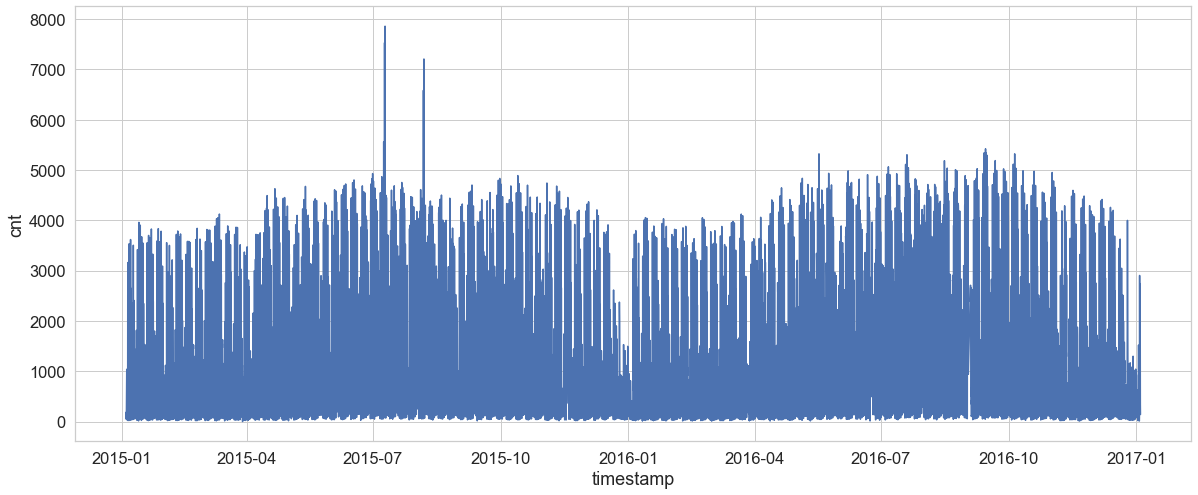

In [6]:
# Построим график
sns.lineplot(data=df, x=df.index, y='cnt');

Как видно из графика, без обработки данных очень сложно что-то понять, поэтому нужно их преобразовать, чтобы увидеть тренды. Воспользуемся методом ```resample```, который позволяет преобразовать временные ряды. Применим метод ```pd.resample()``` и агрегируем данные по дням и посчитаем число аренд за день.

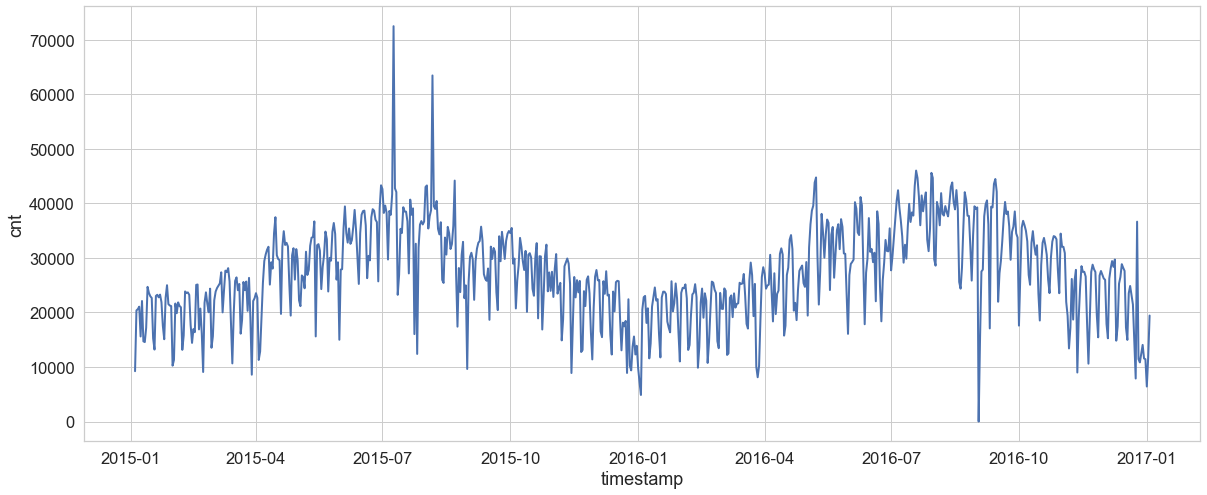

In [7]:
# Преобразуем данные и визуализируем результат
agg_data = df.cnt.resample(rule='1d').sum()
sns.lineplot(data=agg_data, linewidth = 2);

**Выводы:**
- **максимальное число аренд за день составляет более 70 000**
- **зимой число аренд меньше, чем летом**
- **встречаются как очень резкие скачки числа аренд, так и падения**

<hr>

### 3. Посчитайте скользящее среднее с окном 3 и затем разницу между наблюдаемыми значениями и значениями, подсчитанными с помощью скользящего среднего. Определите границы 99% доверительного интервала. Добавьте границы интервалов в датафрейм.

In [8]:
# Возьмем агрегированные данные по дням с предыдущего шага и посчитаем скользящее среднее с окном 3
rolling_3 = agg_data.rolling(window=3).mean()

In [9]:
# Посчитаем разницу между наблюдаемыми и rolling_3 и применим функцию для подсчета стандартного отклонения
sd = np.std(agg_data - rolling_3)
sd

4558.586641117938

In [10]:
# Определим границы 99% доверительного интервала и добавим нижнюю и верхнюю границы в датафрейм
agg_df = agg_data.to_frame().reset_index()
agg_df['lower_bound'] = (rolling_3 - 2.576 * sd).reset_index().drop(columns='timestamp').round(2)
agg_df['upper_bound'] = (rolling_3 + 2.576 * sd).reset_index().drop(columns='timestamp').round(2)
agg_df.head()

,timestamp,cnt,lower_bound,upper_bound
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,4996.75,28482.59
3,2015-01-07,21064,8940.08,32425.92
4,2015-01-08,15601,7349.75,30835.59


<hr>

### 4. Изучите аномально высокие значения и укажите день, когда число аренд было наибольшим. Найдите причину данной аномалии.


Сначала выведем наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

In [11]:
# Установим дату как индекс
agg_df.set_index('timestamp', inplace=True)

In [12]:
# Найдем день с наибольшим числом аренд
max_val = agg_df.loc[agg_df.upper_bound.idxmax()][2]
agg_df.query('cnt > @max_val')

,cnt,lower_bound,upper_bound
timestamp,,,
2015-07-09,72504,38962.08,62447.92


In [13]:
# Посмотрим на этот день в исходном датафрейме более детально
df['2015-07-09']

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-07-09 00:00:00,400,16.0,16.0,55.0,14.0,1.0,0.0,0.0,1.0
2015-07-09 01:00:00,212,15.5,15.5,59.0,14.0,1.0,0.0,0.0,1.0
2015-07-09 02:00:00,111,14.0,14.0,67.0,15.0,1.0,0.0,0.0,1.0
2015-07-09 03:00:00,81,14.0,14.0,63.0,18.5,1.0,0.0,0.0,1.0
2015-07-09 04:00:00,76,14.0,14.0,63.0,18.0,1.0,0.0,0.0,1.0
2015-07-09 05:00:00,269,13.0,13.0,67.0,17.0,1.0,0.0,0.0,1.0
2015-07-09 06:00:00,1724,13.0,13.0,67.0,16.0,1.0,0.0,0.0,1.0
2015-07-09 07:00:00,5309,13.5,13.5,65.0,17.0,1.0,0.0,0.0,1.0
2015-07-09 08:00:00,7531,14.5,14.5,61.0,19.0,2.0,0.0,0.0,1.0


Погодные условия или праздники не являются причиной существенного увеличения спроса на велосипеды. Посмотрим на графике что у нас со спросом по часам.

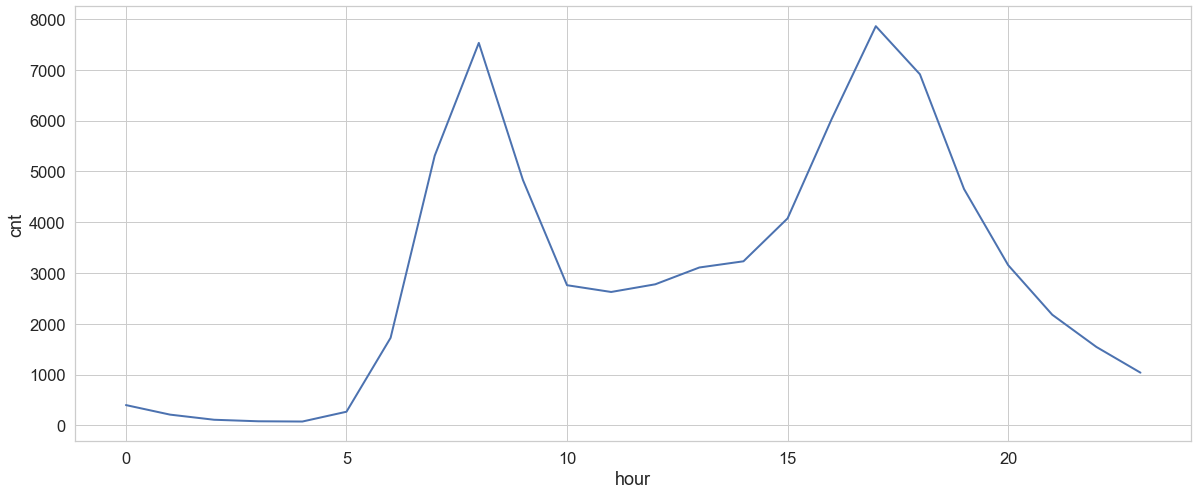

In [14]:
# Визуализируем результат
anomaly_day = df['2015-07-09'].reset_index()
anomaly_day['hour'] = anomaly_day.timestamp.dt.hour
sns.lineplot(data=anomaly_day, x='hour', y='cnt', linewidth = 2);

Из графика видно, что пики спроса находятся в утренние и вечерние часы. Google подсказывает, что в этот день в Лондоне был [транспортный хаос из-за забастовки в метро.](https://www.bbc.com/russian/international/2015/07/150709_london_tube_strike)

<hr>

### 5. Изучите аномально низкие значения, найдите день с наименьшим числом аренд. Найдите причину данной аномалии.

In [15]:
# Найдем день с наименьшим числом аренд
min_val = agg_df.loc[agg_df.lower_bound.idxmin()][1]
agg_df.query('cnt < @min_val')

,cnt,lower_bound,upper_bound
timestamp,,,


In [16]:
# Посмотрим на этот день в исходном датафрейме более детально
df['2016-09-02']

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,


В исходном датафрейме нет никаких данных за этот день. Это может быть обусловлено ошибкой при сборе данных.